In [1]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import matplotlib.pyplot as plt
from datasets import Dataset
from llmft.generate_data.rtc import generate_dataset
import transformers

In [2]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


512


In [3]:
def tokenizer_function(example):
  return tokenizer(example["text"], truncation=True)

In [4]:
dataset = Dataset.from_dict(generate_dataset(flip_rate=0))
dataset = dataset.train_test_split(test_size=0.5, seed=42)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [5]:
def count_tokens(example):
    tokens = tokenizer.tokenize(example['text'])
    return {"num_tokens": len(tokens)}

max(dataset['train'].map(count_tokens)['num_tokens'])

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

34

In [6]:
training_arguments = TrainingArguments(output_dir='./temp',
                   per_device_train_batch_size=4,
                   num_train_epochs=20,
                   logging_strategy="epoch",
                   logging_first_step=True,
                   save_strategy='epoch',
                   evaluation_strategy="epoch",
                   load_best_model_at_end=True)

training_arguments.logging_first_step

True

In [7]:
class EvaluateFirstStepCallback(TrainerCallback):
    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step == 0:
            control.should_evaluate = True
class BestModelLogger(TrainerCallback):
    def __init__(self):
        self.best_metric = float('inf')
        self.best_epoch = None

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        current_metric = metrics["eval_loss"]
        if current_metric < self.best_metric:
            self.best_metric = current_metric
            self.best_epoch = state.epoch
            print(f"New best model found at epoch {self.best_epoch} with loss {self.best_metric:.4f}")

In [21]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model,
                  training_arguments,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  data_collator=data_collator,
                  callbacks=[EvaluateFirstStepCallback(),
                             BestModelLogger(), 
                              EarlyStoppingCallback(early_stopping_patience=3)], 
                 optimizers = (torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), torch.optim.lr_scheduler.ConstantLR))

In [22]:
trainer.train()

TypeError: LRScheduler.step() missing 1 required positional argument: 'self'

: 

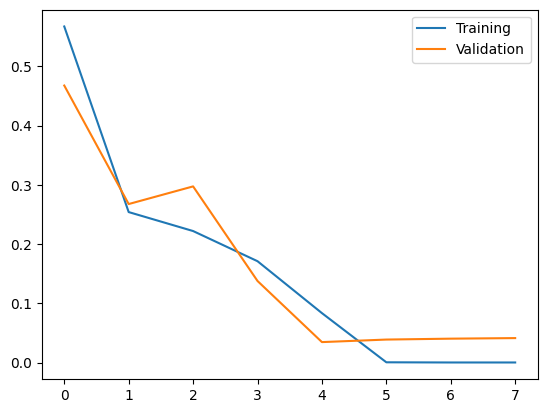

In [10]:
training_loss = []
for i in trainer.state.log_history:
  if 'loss' in i.keys():
    training_loss.append(i['loss'])
validation_loss = []
for i in trainer.state.log_history:
  if 'eval_loss' in i.keys():
    validation_loss.append(i['eval_loss'])
import numpy as np
plt.plot(np.arange(len(training_loss)), training_loss, label='Training')
plt.plot(np.arange(len(training_loss)), validation_loss, label='Validation')
plt.legend()
plt.show()

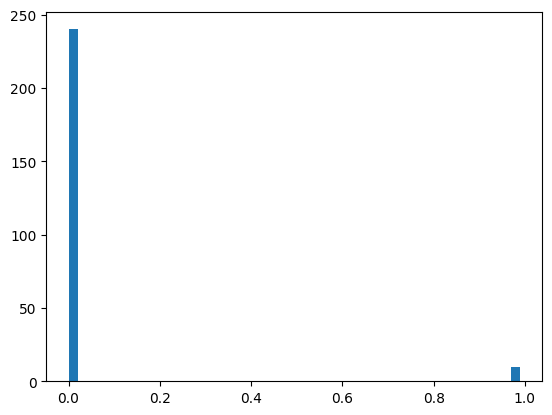

In [11]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset['train']).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50, label='Train')
plt.show()

In [12]:
for i in range(10):
  print(f"Text: {dataset['train']['text'][i]}\nPrediction: {original_predictions[i]}\nTarget: {dataset['train']['label'][i]}\n\n")


Text: No, the Right to Counsel is not in effect in the tenant's zip code. The tenant has installed an unauthorized fence around the property.
Prediction: 0.00020111499179620296
Target: 0


Text: No, the Right to Counsel is not in effect in the tenant's zip code. The tenant conducts loud workout sessions that disturb neighbors.
Prediction: 0.00019979123317170888
Target: 0


Text: Yes, the Right to Counsel is in effect in the tenant's zip code. The tenant is dealing with complications from a previous injury.
Prediction: 0.9865222573280334
Target: 1


Text: No, the Right to Counsel is not in effect in the tenant's zip code. The tenant has not cleaned the pool, violating maintenance agreements.
Prediction: 0.00020220904843881726
Target: 0


Text: Yes, the Right to Counsel is in effect in the tenant's zip code. The tenant made unauthorized structural changes.
Prediction: 0.0001995243364945054
Target: 0


Text: No, the Right to Counsel is not in effect in the tenant's zip code. The tenant ha